# 1. Librerías

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [5]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras_tuner as kt

# 2. Lectura de los datos

In [3]:
# Cragar datos
df_demanda = pd.read_csv('./data/demanda_region.csv')

In [4]:
# Mercados de comercializacion en el dataframe
df_demanda['Values_code'].unique()

array(['ANTIOQUIA', 'ARAUCA', 'BAJO PUTUMAYO', 'BOGOTA - CUNDINAMARCA',
       'BOYACA', 'CALDAS', 'CALI - YUMBO - PUERTO TEJADA', 'CAQUETA',
       'CARIBE MAR', 'CARIBE SOL', 'CARTAGO', 'CASANARE', 'CAUCA',
       'CHOCO', 'GUAVIARE', 'HUILA', 'META', 'NARIÑO',
       'NORTE DE SANTANDER', 'PEREIRA', 'POPAYAN - PURACE', 'PUTUMAYO',
       'QUINDIO', 'RUITOQUE', 'SANTANDER', 'TOLIMA', 'TULUA',
       'VALLE DEL CAUCA', 'VALLE DEL SIBUNDOY', 'SIN CLASIFICAR'],
      dtype=object)

## 2.1. Funciones para modificar los datos

In [5]:
# Función para modificar el dataframe base, agregando la información de días festivos y filtrado de información hasta una fecha específica
def df_ciudad(df, df_festivos, ciudad, fecha):
    df_final = df[df['Values_code'] == ciudad]
    df_final = df_final.drop(columns=['Id', 'Values_code', 'Values_MarketType'])
    df_final['Date'] = pd.to_datetime(df_final['Date'])
    horas = [f'Values_Hour{i:02d}' for i in range(1, 25)]
    df_final['Total'] = df_final[horas].sum(axis=1)
    df_final = df_final.drop(columns=horas)
    df_final = df_final.groupby('Date').sum()
    df_final = df_final.reset_index()
    df_final = df_final.sort_values('Date')
    df_final = df_final.reset_index(drop=True)
    df_final = df_final[df_final['Date'] <= fecha]
    df_final = pd.merge(df_final, df_festivos, on='Date', how='left')
    df_final['Dia'] = df_final['Date'].apply(lambda x: x.weekday())
    return df_final

In [6]:
# Función para crear matriz donde se agrupe la información del día, como el valor de la cantidad de demnanda, día de la semana y si es festivo o no, en un rango de tiempo definido.
def crear_matriz_modelo(df, ventana_entrada=60, ventana_salida=30):
    # Crear una lista para almacenar cada fila de la matriz final
    matriz_final = []
    
    ventana_total = ventana_entrada + ventana_salida
    # Iteramos sobre el DataFrame para extraer ventanas de 60 días
    for i in range(len(df) - ventana_total - 1):
        # Extraemos una ventana de 60 días
        ventana = df.iloc[i:i+ventana_total]
        
        # Reorganizamos la ventana en una sola fila con sufijos para cada día
        fila = {}
        for j in range(ventana_entrada):
            fila[f'fe-{j+1}'] = ventana.iloc[j]['Festivo']
            fila[f'd-{j+1}'] = ventana.iloc[j]['Dia']
            fila[f't-{j+1}'] = ventana.iloc[j]['Total']
        for t in range(ventana_entrada, ventana_total):
            fila[f'fe-{t+1}'] = ventana.iloc[t]['Festivo']
            fila[f'd-{t+1}'] = ventana.iloc[t]['Dia']
            fila[f'r-{t+1-ventana_entrada}'] = ventana.iloc[t]['Total']
        
        # Añadimos la fila al conjunto de la matriz final
        matriz_final.append(fila)
    
    # Convertimos la lista de filas en un DataFrame final
    matriz_dias_df = pd.DataFrame(matriz_final)
    
    return matriz_dias_df

In [7]:
# Función para graficar los resultados de los entrenamientos de los modelos ejecutados
def plot_by_interval(real_values, predicted_values, title, color_real, color_pred, max_plots=10):
    days_interval = 30
    num_plots = min(len(real_values) // days_interval + 1, max_plots)

    fig, axes = plt.subplots(num_plots, 1, figsize=(14, 6 * num_plots))

    if num_plots == 1:
        axes = [axes]

    real_values = real_values.values

    for i in range(num_plots):
        x_values = list(range(1, days_interval + 1))
        x_values_strings = [str(x) for x in x_values]
        axes[i].plot(x_values_strings, real_values[i], color=color_real, label='Real')
        axes[i].plot(x_values_strings, predicted_values[i], color=color_pred, label='Predicción')

        # Configuración de cada subgráfico
        axes[i].set_title(f'{title} - Intervalo {i + 1}')
        axes[i].set_xlabel('Días')
        axes[i].set_ylabel('Valores')
        axes[i].legend()

    # Ajustar la disposición de los subgráficos
    plt.show()

In [8]:
from datetime import datetime, timedelta
import requests

# Función para obtener los días festivos desde Nager.Date API

def obtener_festivos(colombia, anio):
    url = f"https://date.nager.at/api/v3/publicholidays/{anio}/{colombia}"
    
    response = requests.get(url)
    if response.status_code == 200:
        festivos = response.json()
        # Extraer solo las fechas de los festivos
        return [festivo['date'] for festivo in festivos]
    else:
        print(f"Error al obtener festivos para el año {anio}, código de estado {response.status_code}")
        return []

## 2.2. Pre procesamiento de datos

In [9]:
# Crear un rango de fechas desde 2021 hasta septiembre de 2024
fecha_inicio = datetime(2021, 1, 1)
fecha_fin = datetime(2024, 9, 30)

# Crear una lista con todas las fechas en ese rango
fechas = pd.date_range(start=fecha_inicio, end=fecha_fin)

# Obtener los días festivos para cada año de 2021 a 2024
festivos_colombia = []
for anio in range(2021, 2025):
    festivos_colombia.extend(obtener_festivos('CO', anio))

# Convertir las fechas de festivos a formato datetime
festivos_colombia = [datetime.strptime(festivo, "%Y-%m-%d").date() for festivo in festivos_colombia]

# Función para clasificar los días
def clasificar_dia(fecha):
    if fecha in festivos_colombia:
        return 1
    else:
        return 0

# Crear un DataFrame con las fechas y la clasificación
datos = pd.DataFrame({'Date': fechas})
datos['Festivo'] = datos['Date'].apply(lambda x: clasificar_dia(x.date()))

# Guardar la lista en un archivo CSV
datos.to_csv("./data/festivos.csv", index=False)

In [10]:
# Leer csv de festivos
df_festivos = pd.read_csv('./data/festivos.csv')
df_festivos['Date'] = pd.to_datetime(df_festivos['Date'])

In [11]:
df_demanda.fillna(0, inplace=True)                          # Llenar los valores vacíos con 0, asumiendo que no hubo consumo
horas = [f'Values_Hour{i:02d}' for i in range(1, 25)]       # Generar el arreglo Horas para hacer el filtro posterior en el dataset
df_demanda['Total'] = df_demanda[horas].sum(axis=1)         # Crear la columna Total, con la suma del consumo de todas las horas del día
grouped_data = df_demanda.groupby('Values_code')['Total'].sum().reset_index()       # Agrupar la demanda por mercado de comercialización (Región) dado que en el dataset original viene en dos formatos (Mercado Regulado y No Regulado) 
top_ciudades = grouped_data.sort_values(by='Total', ascending=False)['Values_code'].tolist()       # Conocer la lista en orden del consumo de las regiones para organizar la generación de los modelos

In [12]:
top_ciudades

['BOGOTA - CUNDINAMARCA',
 'CARIBE MAR',
 'ANTIOQUIA',
 'CARIBE SOL',
 'CALI - YUMBO - PUERTO TEJADA',
 'SANTANDER',
 'BOYACA',
 'VALLE DEL CAUCA',
 'META',
 'NORTE DE SANTANDER',
 'CALDAS',
 'TOLIMA',
 'HUILA',
 'CAUCA',
 'ARAUCA',
 'NARIÑO',
 'PEREIRA',
 'CASANARE',
 'QUINDIO',
 'CAQUETA',
 'CHOCO',
 'TULUA',
 'CARTAGO',
 'PUTUMAYO',
 'BAJO PUTUMAYO',
 'GUAVIARE',
 'RUITOQUE',
 'VALLE DEL SIBUNDOY',
 'POPAYAN - PURACE',
 'SIN CLASIFICAR']

## 2.3. Selección Ciduad

In [ ]:
ciudad = top_ciudades[0]

In [13]:
df_demanda_ciudades = {}            # Arreglo vacío para guardar los datasets individuales por región
fecha = '2024-09-30'                # Fecha de filtrado de la información, se define dado que al momento de realizar los modelos era el último mes con información completa en la API de XM
for i in top_ciudades:
    j = top_ciudades.index(i)
    df_demanda_ciudades[i] = df_ciudad(df_demanda, df_festivos, top_ciudades[j], fecha)        # Generación del arreglo con los datasets de las regiones, el apuntador es el nombre de la región, no un número en algún orden

In [ ]:
matriz_modelo = {}                  # Arreglo vació para guardar las matrices de cada región para el modelo
matriz_modelo[ciudad] = crear_matriz_modelo(df_demanda_ciudades[ciudad], 60, 30)        # Se define un rango de 60 días en el pasado y 30 días en el futuro para la predicción

# 3. Generación de modelos

## 3.1. Funciones para generar los modelos

### 3.1.1. MLP

In [15]:
# Definir la función para construir el modelo MLP en búsqueda de hiperparámetros
def build_model_mlp(hp):
    model = Sequential(name="MLP")
    
    # Hiperparámetros para las capas ocultas, los rangos se pueden modificar, así como los pasos y la función de activación
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), input_dim=240, activation='relu'))           # Primera capa dense, donde se define el rango de entrada, este valor depende de la matriz modelo
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))                          # Segunda capa dense
    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32), activation='relu'))                          # Tercera capa dense
    
    # Capa de salida
    model.add(Dense(30, activation='linear'))       # Capa dense de salida, se define el valor 30 dado que se estan prediciendo 30 días únicamente, si se desea aumentar el rango este valor también debe cambiar

    # Optimización de la tasa de aprendizaje
    model.compile(loss='mae', 
                  optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=0.001)))
    
    return model

In [18]:
# Función para generar el modelo MLP, con entrada el nombre del proyecto para almacenar los intentos y la matriz modelo de cada una de las regiones
def generate_model_MLP(matriz_modelo, project_name):
    X = matriz_modelo.drop(columns=[f'r-{i+1}' for i in range(30)])     # Generación de las entradas, eliminando las columnas del resultado
    y = matriz_modelo[[f'r-{i+1}' for i in range(30)]]                  # Generación de las salidas, solo definiendo la columna del resultado

    # Obtener el primer 70% de los datos
    corte = int(0.7 * len(X))

    X_train = X.iloc[:corte]
    X_test = X.iloc[corte:]

    Y_train = y.iloc[:corte]
    Y_test = y.iloc[corte:]

    # Crear el objeto de búsqueda de hiperparámetros
    tuner = kt.Hyperband(build_model_mlp, 
                        objective='val_loss', 
                        max_epochs=20, 
                        hyperband_iterations=2, 
                        directory='ejecucion',             # Nombre del directorio donde se almacenan los intentos de búsqueda de hiperparámetros
                        project_name=project_name)      # Nombre del proyecto por modelo, debe ser diferente para que no cruce información y entrene de manera correcta

    # Parada temprana para evitar sobreajuste
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Ejecutar la búsqueda de hiperparámetros
    tuner.search(X_train, Y_train, 
                validation_split=0.2, 
                epochs=50, 
                batch_size=64, 
                callbacks=[early_stopping])

    # Obtener el mejor modelo
    best_model_MLP = tuner.get_best_models(num_models=1)[0]

    # Evaluar el modelo con los datos de prueba
    loss = best_model_MLP.evaluate(X_test, Y_test)
    print("Test Loss:", loss)

    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    best_hyperparameters_MLP = best_trial.hyperparameters.values

    testPredict = best_model_MLP.predict(X_test)

    # Graficamos los primeros 3 intervalos de prueba
    plot_by_interval(Y_test, testPredict, 'Resultados de Prueba', 'green', 'red', max_plots=3)

    return best_model_MLP, best_hyperparameters_MLP

### 3.1.2. CNN

In [16]:
# Definir la función para construir el modelo CNN en búsqueda de hiperparámetros
def build_model_CNN(hp):
    model = Sequential(name="CNN")

    # Primera capa convolucional con hiperparámetros para filtros y tamaño de kernel
    model.add(Conv1D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=7, step=2), 
                     activation='relu', input_shape=(240, 1)))
    model.add(MaxPooling1D(pool_size=2))  # Reducción de dimensionalidad

    # Segunda capa convolucional con filtros y tamaño de kernel optimizados
    model.add(Conv1D(filters=hp.Int('filters_2', min_value=64, max_value=256, step=64), 
                     kernel_size=hp.Int('kernel_size_2', min_value=3, max_value=7, step=2), 
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Aplanar y agregar capas densas
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units_dense', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dense(30, activation='linear'))       # Capa dense de salida, se define el valor 30 dado que se estan prediciendo 30 días únicamente, si se desea aumentar el rango este valor también debe cambiar

    # Optimización de la tasa de aprendizaje
    model.compile(loss='mae', 
                  optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=0.001)))

    return model

In [19]:
# Función para generar el modelo CNN, con entrada el nombre del proyecto para almacenar los intentos y la matriz modelo de cada una de las regiones
def generate_model_CNN(matriz_modelo, project_name):
    X = matriz_modelo.drop(columns=[f'r-{i+1}' for i in range(30)])     # Generación de las entradas, eliminando las columnas del resultado
    y = matriz_modelo[[f'r-{i+1}' for i in range(30)]]                  # Generación de las salidas, solo definiendo la columna del resultado

    # Obtener el primer 70% de los datos
    corte = int(0.7 * len(X))

    X_train = X.iloc[:corte]
    X_test = X.iloc[corte:]

    Y_train = y.iloc[:corte]
    Y_test = y.iloc[corte:]

    # Crear el objeto de búsqueda de hiperparámetros
    tuner = kt.Hyperband(build_model_CNN, 
                        objective='val_loss', 
                        max_epochs=20, 
                        hyperband_iterations=2, 
                        directory='ejecucion',             # Nombre del directorio donde se almacenan los intentos de búsqueda de hiperparámetros
                        project_name=project_name)      # Nombre del proyecto por modelo, debe ser diferente para que no cruce información y entrene de manera correcta

    # Parada temprana para evitar sobreajuste
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Ejecutar la búsqueda de hiperparámetros
    tuner.search(X_train, Y_train, 
                validation_split=0.2, 
                epochs=50, 
                batch_size=64, 
                callbacks=[early_stopping])

    # Obtener el mejor modelo
    best_model_CNN = tuner.get_best_models(num_models=1)[0]

    # Evaluar el modelo con los datos de prueba
    loss = best_model_CNN.evaluate(X_test, Y_test)
    print("Test Loss:", loss)

    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    best_hyperparameters_CNN = best_trial.hyperparameters.values

    testPredict = best_model_CNN.predict(X_test)
    
    # Graficamos los primeros 3 intervalos de prueba
    plot_by_interval(Y_test, testPredict, 'Resultados de Prueba', 'green', 'red', max_plots=3)

    return best_model_CNN, best_hyperparameters_CNN

### 3.1.3 LSTM

In [17]:
def build_model_LSTM(hp):
    # Crear y ajustar la red LSTM
    model = Sequential(name="LSTM_Advanced")
    
    # Primera capa LSTM con número de unidades como hiperparámetro
    model.add(LSTM(
        units=hp.Int('units_layer1', min_value=64, max_value=256, step=32),
        return_sequences=True, 
        input_shape=(1, 240), 
        name='LSTM_Layer1'
    ))
    model.add(Dropout(hp.Float('dropout_layer1', min_value=0.1, max_value=0.5, step=0.1), name='Dropout_Layer1'))
    
    # Segunda capa LSTM con número de unidades como hiperparámetro
    model.add(LSTM(
        units=hp.Int('units_layer2', min_value=32, max_value=128, step=32),
        return_sequences=False, 
        name='LSTM_Layer2'
    ))
    model.add(Dropout(hp.Float('dropout_layer2', min_value=0.1, max_value=0.5, step=0.1), name='Dropout_Layer2'))
    
    # Capa densa intermedia
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16), 
        activation='relu', 
        name='Dense_Layer1'
    ))
    model.add(Dropout(hp.Float('dropout_layer3', min_value=0.1, max_value=0.5, step=0.1), name='Dropout_Layer3'))
    
    # Capa de salida
    model.add(Dense(30, activation='linear', name='Output_Layer'))
    
    # Compilación del modelo con tasa de aprendizaje como hiperparámetro
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
    )
    return model

In [20]:
from keras_tuner import RandomSearch
def generate_model_LSTM(matriz_modelo, project_name):
    X = matriz_modelo.drop(columns=[f'r-{i+1}' for i in range(30)])     # Generación de las entradas, eliminando las columnas del resultado
    y = matriz_modelo[[f'r-{i+1}' for i in range(30)]]                  # Generación de las salidas, solo definiendo la columna del resultado

    # Obtener el primer 70% de los datos
    corte = int(0.7 * len(X))

    X_train = X.iloc[:corte]
    X_test = X.iloc[corte:]

    Y_train = y.iloc[:corte]
    Y_test = y.iloc[corte:]

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    tuner = RandomSearch(build_model_LSTM, 
                        objective='val_loss',
                        max_trials=10,  # Número de configuraciones diferentes que se probarán
                        executions_per_trial=1,  # Número de veces que se ejecutará cada configuración
                        directory='ejecucion',
                        project_name=project_name)
    
    # Parada temprana para evitar sobreajuste
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Ejecutar la búsqueda de hiperparámetros
    tuner.search(X_train, Y_train, 
                validation_split=0.2, 
                epochs=50, 
                batch_size=64, 
                callbacks=[early_stopping])
    
    best_model_LSTM = tuner.get_best_models(num_models=1)[0]

    # Evaluar el modelo con los datos de prueba
    loss = best_model_LSTM.evaluate(X_test, Y_test)
    print("Test Loss:", loss)

    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    best_hyperparameters_LSTM = best_trial.hyperparameters.values

    testPredict = best_model_LSTM.predict(X_test)
    
    # Graficamos los primeros 3 intervalos de prueba
    plot_by_interval(Y_test, testPredict, 'Resultados de Prueba', 'green', 'red', max_plots=3)

    return best_model_LSTM, best_hyperparameters_LSTM

## 3.2. Generación de los modelos por región

Trial 10 Complete [00h 00m 31s]
val_loss: 1979292862906368.0

Best val_loss So Far: 1974235941568512.0
Total elapsed time: 00h 05m 01s


c:\Users\Nicolas Estepa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Nicolas Estepa\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2020846671495168.0000 
Test Loss: 1999080179892224.0
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  


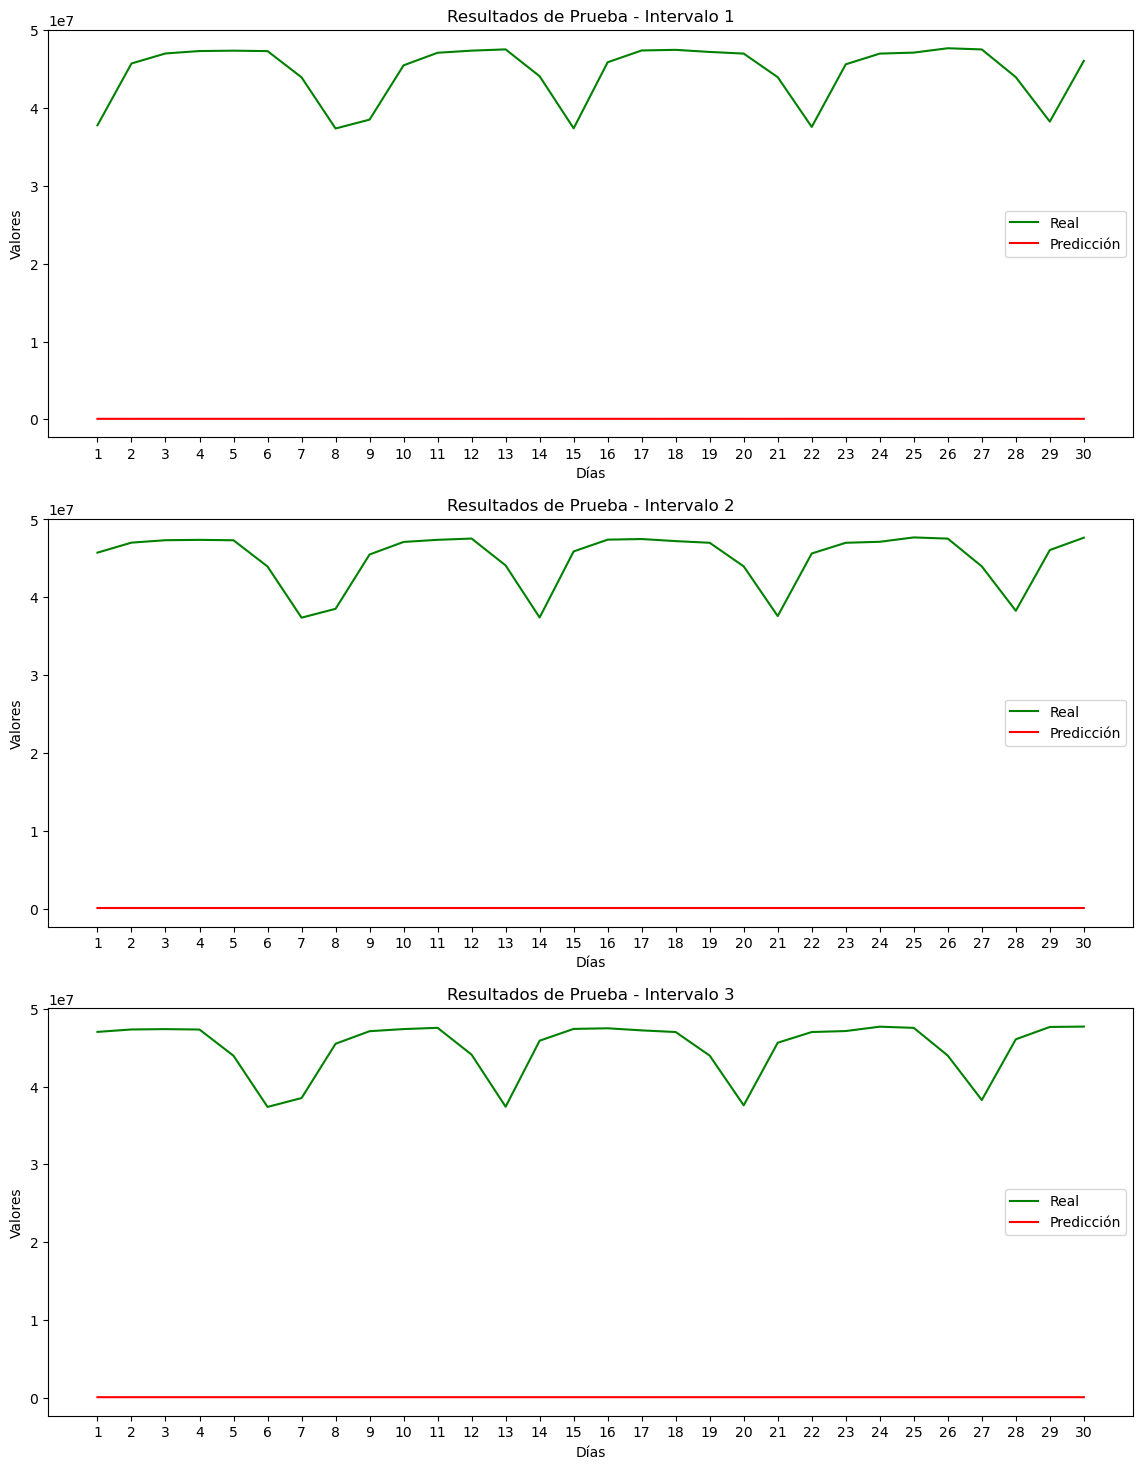

In [ ]:
best_model_MLP = {}                     # Arreglo vacío para guardar los resultados de los modelos de tipo MLP de cada región
best_hyperparameters_MLP = {}           # Arreglo vacío para guardar los resultados de los hiperparámetros de los modelos de tipo MLP de cada región
best_model_CNN = {}                     # Arreglo vacío para guardar los resultados de los modelos de tipo CNN de cada región
best_hyperparameters_CNN = {}           # Arreglo vacío para guardar los resultados de los hiperparámetros de los modelos de tipo CNN de cada región
best_model_LSTM = {}                     # Arreglo vacío para guardar los resultados de los modelos de tipo LSTM de cada región
best_hyperparameters_LSTM = {}           # Arreglo vacío para guardar los resultados de los hiperparámetros de los modelos de tipo LSTM de cada región

best_model_MLP[ciudad], best_hyperparameters_MLP[ciudad] = generate_model_MLP(matriz_modelo[ciudad], "MLP_tunning_0")
best_model_CNN[ciudad], best_hyperparameters_CNN[ciudad] = generate_model_CNN(matriz_modelo[ciudad], "CNN_tunning_0")
best_model_LSTM[ciudad], best_hyperparameters_LSTM[ciudad] = generate_model_LSTM(matriz_modelo[ciudad], "LSTM_tunning_0")

# 4. Pruebas métricas para selección del modelo

## 4.1. Funciones necesarias para el cálculo

In [22]:
# Calculo de las métricas MSE y MAE para la comparación de resultados
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {"MSE": mse, "MAE": mae}

In [ ]:
# Función necesaria para reconocer el modelo LSTM, debido a que es necesario modificar el formato para evaluar el modelo
def is_lstm_model(model):
    for layer in model.layers:
        if isinstance(layer, LSTM):
            return True
    return False

In [ ]:
from sklearn.model_selection import train_test_split

# Ejecución de pruebas A/B para comparar las metricas MSE y MAE para escoger el mejor modelo
def pruebas_ab(control, variant, matriz_modelo, ciudad):
    X = matriz_modelo.drop(columns=[f'r-{i+1}' for i in range(30)])
    y = matriz_modelo[[f'r-{i+1}' for i in range(30)]]

    xtestA, xtestB, ytestA, ytestB = train_test_split(X, y, test_size=0.5)

    if is_lstm_model(control):
        xtestA = np.reshape(xtestA, (xtestA.shape[0], 1, xtestA.shape[1]))      # Modificación del formato de la entrada para evualar el modelo LSTM

    if is_lstm_model(variant):
        xtestB = np.reshape(xtestB, (xtestB.shape[0], 1, xtestB.shape[1]))      # Modificación del formato de la entrada para evualar el modelo LSTM
    
    ypred_control=control.predict(xtestA)
    ypred_variant=variant.predict(xtestB)

    # Métricas para cada modelo
    metrics_control = calcular_metricas(ytestA, ypred_control)
    metrics_variant = calcular_metricas(ytestB, ypred_variant)

    print(f"Métricas Modelo A de {ciudad}:", metrics_control)
    print(f"Métricas Modelo B de {ciudad}:", metrics_variant)

    # Se escoge el mejor modelo a partir del que tenga menor error absoluto
    if metrics_control["MAE"] < metrics_variant["MAE"]:
        mejor_modelo = control
        mejores_metricas = metrics_control         
    else:
        mejor_modelo = variant
        mejores_metricas = metrics_variant

    return mejor_modelo, mejores_metricas       # Retorno de las metricas y mejor modelo para evaluar en un futuro el modelo

## 4.2. Obtención del mejor modelo a partir de pruebas A/B

In [ ]:
mejor_modelo = {}           # Arreglo vacío para almacenar el mejor modelo por región
metrics = {}        # Arreglo vacío para las metricas del mejro modelo

mejor_modelo[ciudad], metrics[ciudad] = pruebas_ab(best_model_MLP[ciudad], best_model_CNN[ciudad], matriz_modelo[ciudad], ciudad)       # Almacenamiento del mejor modelo por región, el apuntador es el nombre de la región
mejor_modelo[ciudad], metrics[ciudad] = pruebas_ab(mejor_modelo[ciudad], best_model_LSTM[ciudad], matriz_modelo[ciudad], ciudad)       # Almacenamiento del mejor modelo por región, el apuntador es el nombre de la región
mejor_modelo[ciudad].save(f"./modelos_ejecución/{ciudad}.h5")       # Almacenamiento del modelo en la ruta ./modelos con el nombre de la región

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Métricas Modelo A de BOGOTA - CUNDINAMARCA: {'MSE': 7677830785575.56, 'MAE': 1879734.2187203967}
Métricas Modelo B de BOGOTA - CUNDINAMARCA: {'MSE': 7200030850858.213, 'MAE': 1673183.2112999484}
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Métricas Modelo A de BOGOTA - CUNDINAMARCA: {'MSE': 6865938033081.458, 'MAE': 1643817.3121163284}
Métricas Modelo B de BOGOTA - CUNDINAMARCA: {'MSE': 1946173066986877.5, 'MAE': 43952116.6416064}


## 4.3. Visualización de resultados

In [ ]:
def plot_result(modelo, matriz_modelo, ciudad):
    X = matriz_modelo.drop(columns=[f'r-{i+1}' for i in range(30)])     # Generación de las entradas, eliminando las columnas del resultado
    y = matriz_modelo[[f'r-{i+1}' for i in range(30)]]

    y_predict = modelo.predict(X)

    plot_by_interval(y, y_predict, f"Resultados de Prueba región {ciudad}", 'green', 'red', max_plots=1)

In [ ]:
plot_result(mejor_modelo[ciudad], matriz_modelo[ciudad], ciudad)